In [1]:
pip install rouge-score

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
def fix_apostrophes(text):
    return text.replace('apos', "'")

def prepare_input(sentences):
    return ". ".join(sentences)

def clean_summary(summary):
    # Remove repetitive endings and weird characters
    words = summary.split()
    cleaned_words = []
    for word in words:
        if len(word) > 1 or word.lower() in ['a', 'i']:  # Keep only meaningful words
            if len(cleaned_words) < 2 or word != cleaned_words[-1] or word != cleaned_words[-2]:
                cleaned_words.append(word)
    return ' '.join(cleaned_words).strip()

In [4]:
url = "https://raw.githubusercontent.com/zhangke626/w266_project/main/training_data_with_objectivity.csv"
df = pd.read_csv(url)

url = "https://raw.githubusercontent.com/zhangke626/w266_project/main/initial_data.csv"
df_article = pd.read_csv(url)

objective_sentences = df[df['objectivity_score'] == 1].copy()
# Fix apostrophes in individual sentences
objective_sentences.loc[:, 'sentence'] = objective_sentences['sentence'].apply(fix_apostrophes)

# Now proceed with grouping and creating input_text
grouped_sentences = objective_sentences.groupby('title')['sentence'].apply(list).reset_index()

grouped_sentences['input_text'] = grouped_sentences['sentence'].apply(prepare_input)

# Merge with df_article
grouped_sentences = grouped_sentences.merge(df_article[['title', 'article', 'publication', 'section', 'url']], on='title', how='left')

In [5]:
df_article_titles = set(df_article['title'])
grouped_sentences_titles = set(grouped_sentences['title'])

missing_titles = df_article_titles - grouped_sentences_titles

print(f"Number of missing titles: {len(missing_titles)}")
print("Missing titles:")
for title in missing_titles:
    print(title)

Number of missing titles: 3
Missing titles:
BIRTHDAY OF THE DAY: Sen. Michael Bennet (D-Colo.)
Tim Kaine's convention speech: 5 moments that made a splash on Twitter
Should Democrats Fear Trump?


In [6]:
grouped_sentences[grouped_sentences['title']=='Russia struggles with legacy of 1917 Bolshevik Revolution'].input_text

607    next image 1 of 2 prev image 2 of 2 moscow  th...
Name: input_text, dtype: object

In [7]:
sample_size = 5

random_seed = 42
random.seed(random_seed)

# Create an empty list to store the sampled DataFrames
sampled_dfs = []

# Group by publication and sample 10 rows from each

for publication, group in grouped_sentences.groupby('publication'):
    sampled_group = group.sample(n=min(sample_size, len(group)), random_state=random_seed)
    sampled_dfs.append(sampled_group)

# Concatenate all the sampled DataFrames
test_df = pd.concat(sampled_dfs, ignore_index=True)

# Shuffle the final DataFrame to mix the publications
test_df = test_df.sample(frac=1, random_state=random_seed).reset_index(drop=True)

test_df.head()

,title,sentence,input_text,article,publication,section,url
0,States Move Toward Treating 17-Year-Old Offend...,[then a 17yearold junior with no criminal reco...,then a 17yearold junior with no criminal recor...,NEW ORLEANS — When Chené Marshall got into a f...,The New York Times,us,http://www.nytimes.com/2016/05/14/us/states-mo...
1,Johnson 'cautious' ahead of Brexit talks in Lu...,[luxembourg reuters british prime minister bo...,luxembourg reuters british prime minister bor...,LUXEMBOURG (Reuters) - British Prime Minister ...,Reuters,World News,https://www.reuters.com/article/us-britain-eu-...
2,Paul Manafort's former son-in-law sentenced to...,[the associated press reports us district judg...,the associated press reports us district judge...,Paul ManafortPaul John ManafortManafort sought...,The Hill,NaN,https://thehill.com/blogs/blog-briefing-room/n...
3,Trump hopes U.S.-China trade deal will be sign...,[washington oct 18 reuters president donald t...,washington oct 18 reuters president donald tr...,"WASHINGTON, Oct 18 (Reuters) - President Donal...",Reuters,Industrials,https://www.reuters.com/article/usa-china-trad...
4,Momentous days in Ethiopia as new PM pledges m...,[sweeping changes that seemed unthinkable just...,sweeping changes that seemed unthinkable just ...,"ADDIS ABABA, Ethiopia – These are not ordinar...",Fox News,World,https://www.foxnews.com/world/momentous-days-i...


articles missing due to very low length and not objective

## **Experimenting with Pegasus**

In [8]:
import re
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

model_name = "google/pegasus-large"  # You can try "google/pegasus-xsum" for a smaller model
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def count_tokens(text):
    return len(tokenizer.encode(text))

# Calculate token counts for each article
grouped_sentences['token_count'] = grouped_sentences['input_text'].apply(count_tokens)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

C:\Users\ez4ke.KDAWG\anaconda3\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ez4ke.KDAWG\.cache\huggingface\hub\models--google--pegasus-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1214 > 1024). Running this sequence through the model will result in indexing errors


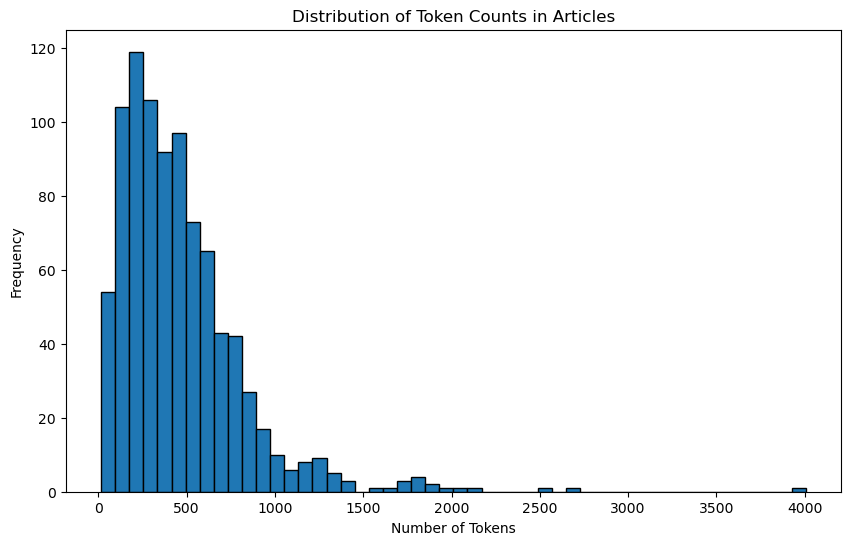


Percentiles of token counts:
10th percentile: 132
25th percentile: 221
50th percentile: 393
75th percentile: 601
90th percentile: 850
95th percentile: 1096
99th percentile: 1829


In [9]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(grouped_sentences['token_count'], bins=50, edgecolor='black')
plt.title('Distribution of Token Counts in Articles')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

# Print some percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
print("\nPercentiles of token counts:")
for p in percentiles:
    print(f"{p}th percentile: {grouped_sentences['token_count'].quantile(p/100):.0f}")

In [ ]:
import re
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

model_name = "google/pegasus-large"  # You can try "google/pegasus-xsum" for a smaller model
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def generate_summary(text):
    try:
        # Clean input text
        cleaned_text = clean_text(text)

        # Truncate input if it's too long
        max_input_length = 1024  # PEGASUS typically uses a smaller input size
        input_ids = tokenizer(cleaned_text, return_tensors="pt", max_length=max_input_length, truncation=True).input_ids.to(device)

        # Generate summary
        summary_ids = model.generate(
            input_ids,
            max_length=400,  # Adjust as needed
            min_length=100,   # Adjust as needed
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True,
        )

        # Decode and clean summary
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summary = clean_text(summary)

        # Remove any remaining non-standard characters
        summary = re.sub(r'[^a-zA-Z0-9.,!?;\'\"\s]', '', summary)

        # Remove repetitive endings and weird characters
        summary = clean_summary(tokenizer.decode(summary_ids[0], skip_special_tokens=True))

        return summary

    except Exception as e:
        print(f"Error generating summary: {str(e)}")
        return "Error in summarization process."


test_df['summary'] = test_df['input_text'].apply(generate_summary)

from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge(reference, hypothesis):
    scores = scorer.score(reference, hypothesis)
    return scores

test_df['rouge_scores'] = test_df.apply(lambda row: calculate_rouge(row['article'], row['summary']), axis=1)

# Extracting all ROUGE metrics
test_df['rouge1_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].precision)
test_df['rouge1_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].recall)
test_df['rouge1_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].fmeasure)

test_df['rouge2_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].precision)
test_df['rouge2_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].recall)
test_df['rouge2_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].fmeasure)

test_df['rougeL_precision'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].precision)
test_df['rougeL_recall'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].recall)
test_df['rougeL_f1'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].fmeasure)

print("Average ROUGE scores:")
print(f"ROUGE-1: {test_df['rouge1_f1'].mean():.4f}")
print(f"ROUGE-2: {test_df['rouge2_f1'].mean():.4f}")
print(f"ROUGE-L: {test_df['rougeL_f1'].mean():.4f}")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
test_df.to_csv('test_pegasus_fixed.csv')

In [ ]:
from google.colab import files
test_df.to_csv('test_pegasus_fixed.csv')
files.download('test_pegasus_fixed.csv')

### Instead of using arbitrary length, let's find the actual max_length based on the data




In [ ]:
import re
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

model_name = "google/pegasus-large"  # You can try "google/pegasus-xsum" for a smaller model
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def generate_summary(text):
    try:
        # Clean input text
        cleaned_text = clean_text(text)

        # Count tokens in the input text
        input_token_count = len(tokenizer.encode(cleaned_text))

        # Set dynamic max_length and min_length
        max_length = int(input_token_count * 0.4) # 40% of input
        min_length = int(input_token_count * 0.1)  # 10% of input

        # Ensure min_length is not greater than max_length
        min_length = min(min_length, max_length - 1)

        # Truncate input if it's too long
        max_input_length = 1024  # PEGASUS typically uses a smaller input size
        input_ids = tokenizer(cleaned_text, return_tensors="pt", max_length=max_input_length, truncation=True).input_ids.to(device)

        # Generate summary
        summary_ids = model.generate(
            input_ids,
            max_length=max_length,
            min_length=min_length,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True,
        )

        # Decode and clean summary
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summary = clean_text(summary)

        # Remove any remaining non-standard characters
        summary = re.sub(r'[^a-zA-Z0-9.,!?;\'\"\s]', '', summary)

        # Remove repetitive endings and weird characters
        summary = clean_summary(tokenizer.decode(summary_ids[0], skip_special_tokens=True))

        return summary

    except Exception as e:
        print(f"Error generating summary: {str(e)}")
        return "Error in summarization process."


test_df['summary'] = test_df['input_text'].apply(generate_summary)


from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge(reference, hypothesis):
    scores = scorer.score(reference, hypothesis)
    return scores

test_df['rouge_scores'] = test_df.apply(lambda row: calculate_rouge(row['article'], row['summary']), axis=1)

# Extracting all ROUGE metrics
test_df['rouge1_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].precision)
test_df['rouge1_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].recall)
test_df['rouge1_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].fmeasure)

test_df['rouge2_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].precision)
test_df['rouge2_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].recall)
test_df['rouge2_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].fmeasure)

test_df['rougeL_precision'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].precision)
test_df['rougeL_recall'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].recall)
test_df['rougeL_f1'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].fmeasure)

print("Average ROUGE scores:")
print(f"ROUGE-1: {test_df['rouge1_f1'].mean():.4f}")
print(f"ROUGE-2: {test_df['rouge2_f1'].mean():.4f}")
print(f"ROUGE-L: {test_df['rougeL_f1'].mean():.4f}")

In [ ]:
from google.colab import files
test_df.to_csv('test_pegasus_var.csv')
files.download('test_pegasus_var.csv')

## **Expirimenting with T5**

In [ ]:
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

model_name = "t5-large"  # You can try "google/pegasus-xsum" for a smaller model
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def count_tokens(text):
    return len(tokenizer.encode(text))

# Calculate token counts for each article
grouped_sentences['token_count'] = grouped_sentences['input_text'].apply(count_tokens)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(grouped_sentences['token_count'], bins=50, edgecolor='black')
plt.title('Distribution of Token Counts in Articles')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

# Print some percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
print("\nPercentiles of token counts:")
for p in percentiles:
    print(f"{p}th percentile: {grouped_sentences['token_count'].quantile(p/100):.0f}")

In [ ]:
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

model_name = "t5-large"  # You can try "t5-small" if you're having memory issues
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def generate_summary(text):
    try:
        # Clean input text
        cleaned_text = clean_text(text)

        # Truncate input if it's too long
        max_input_length = 2048
        input_ids = tokenizer.encode("summarize: " + cleaned_text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)

        # Generate summary
        summary_ids = model.generate(
            input_ids,
            max_length=400,  # Adjust as needed
            min_length=100,   # Adjust as needed
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True,
        )

        # Decode and clean summary
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summary = clean_text(summary)

        # Remove any remaining non-standard characters
        summary = re.sub(r'[^a-zA-Z0-9.,!?;\'\"\s]', '', summary)

        # Remove repetitive endings and weird characters
        summary = clean_summary(tokenizer.decode(summary_ids[0], skip_special_tokens=True))

        return summary

    except Exception as e:
        print(f"Error generating summary: {str(e)}")
        return "Error in summarization process."


test_df['summary'] = test_df['input_text'].apply(generate_summary)


from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge(reference, hypothesis):
    scores = scorer.score(reference, hypothesis)
    return scores

test_df['rouge_scores'] = test_df.apply(lambda row: calculate_rouge(row['article'], row['summary']), axis=1)

# Extracting all ROUGE metrics
test_df['rouge1_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].precision)
test_df['rouge1_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].recall)
test_df['rouge1_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].fmeasure)

test_df['rouge2_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].precision)
test_df['rouge2_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].recall)
test_df['rouge2_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].fmeasure)

test_df['rougeL_precision'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].precision)
test_df['rougeL_recall'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].recall)
test_df['rougeL_f1'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].fmeasure)

print("Average ROUGE scores:")
print(f"ROUGE-1: {test_df['rouge1_f1'].mean():.4f}")
print(f"ROUGE-2: {test_df['rouge2_f1'].mean():.4f}")
print(f"ROUGE-L: {test_df['rougeL_f1'].mean():.4f}")

In [ ]:
from google.colab import files
test_df.to_csv('test_t5_fixed.csv')
files.download('test_t5_fixed.csv')

Experimenting with length

In [ ]:
import re
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

model_name = "t5-large"  # You can try "t5-small" if you're having memory issues
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def generate_summary(text):
    try:
        # Clean input text
        cleaned_text = clean_text(text)

        # Count tokens in the input text
        input_token_count = len(tokenizer.encode(cleaned_text))

        # Set dynamic max_length and min_length
        max_length = int(input_token_count * 0.4) # 40% of input
        min_length = int(input_token_count * 0.1)  # 20% of input

        # Ensure min_length is not greater than max_length
        min_length = min(min_length, max_length - 1)

        # Truncate input if it's too long
        max_input_length = 2048  # T5 typically uses a smaller input size
        input_ids = tokenizer.encode("summarize: " + cleaned_text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)

        # Generate summary
        summary_ids = model.generate(
            input_ids,
            max_length=max_length,
            min_length=min_length,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True,
        )

        # Decode and clean summary
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summary = clean_text(summary)

        # Remove any remaining non-standard characters
        summary = re.sub(r'[^a-zA-Z0-9.,!?;\'\"\s]', '', summary)

        # Remove repetitive endings and weird characters
        summary = clean_summary(tokenizer.decode(summary_ids[0], skip_special_tokens=True))

        return summary

    except Exception as e:
        print(f"Error generating summary: {str(e)}")
        return "Error in summarization process."


test_df['summary'] = test_df['input_text'].apply(generate_summary)


from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge(reference, hypothesis):
    scores = scorer.score(reference, hypothesis)
    return scores

test_df['rouge_scores'] = test_df.apply(lambda row: calculate_rouge(row['article'], row['summary']), axis=1)

# Extracting all ROUGE metrics
test_df['rouge1_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].precision)
test_df['rouge1_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].recall)
test_df['rouge1_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge1'].fmeasure)

test_df['rouge2_precision'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].precision)
test_df['rouge2_recall'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].recall)
test_df['rouge2_f1'] = test_df['rouge_scores'].apply(lambda x: x['rouge2'].fmeasure)

test_df['rougeL_precision'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].precision)
test_df['rougeL_recall'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].recall)
test_df['rougeL_f1'] = test_df['rouge_scores'].apply(lambda x: x['rougeL'].fmeasure)

print("Average ROUGE scores:")
print(f"ROUGE-1: {test_df['rouge1_f1'].mean():.4f}")
print(f"ROUGE-2: {test_df['rouge2_f1'].mean():.4f}")
print(f"ROUGE-L: {test_df['rougeL_f1'].mean():.4f}")

In [ ]:
from google.colab import files
test_df.to_csv('test_t5_var.csv')
files.download('test_t5_var.csv')

## Compilation of the test dataframes

In [ ]:
df_t5_var = pd.read_csv('test_t5_var.csv')
df_t5_fixed  = pd.read_csv('test_t5_fixed.csv')
df_pegasus_var  = pd.read_csv('test_pegasus_var.csv')
df_pegasus_fixed  = pd.read_csv('test_pegasus_fixed.csv')

In [ ]:
# Extract relevant columns and rename them for clarity
df_t5_var = df_t5_var[['title', 'input_text', 'summary', 'rouge1_precision', 'rouge1_recall', 'rouge1_f1',
                       'rouge2_precision', 'rouge2_recall', 'rouge2_f1', 'rougeL_precision', 'rougeL_recall', 'rougeL_f1']]
df_pegasus_fixed = df_pegasus_fixed[['title', 'input_text', 'summary', 'rouge1_precision', 'rouge1_recall', 'rouge1_f1',
                                     'rouge2_precision', 'rouge2_recall', 'rouge2_f1', 'rougeL_precision', 'rougeL_recall', 'rougeL_f1']]
df_t5_fixed = df_t5_fixed[['title', 'input_text', 'summary', 'rouge1_precision', 'rouge1_recall', 'rouge1_f1',
                           'rouge2_precision', 'rouge2_recall', 'rouge2_f1', 'rougeL_precision', 'rougeL_recall', 'rougeL_f1']]
df_pegasus_var = df_pegasus_var[['title', 'input_text', 'summary', 'rouge1_precision', 'rouge1_recall', 'rouge1_f1',
                                 'rouge2_precision', 'rouge2_recall', 'rouge2_f1', 'rougeL_precision', 'rougeL_recall', 'rougeL_f1']]

# Rename columns to include model information
df_t5_var.columns = ['title', 'input_text', 'summary_t5_var', 'rouge1_precision_t5_var', 'rouge1_recall_t5_var', 'rouge1_f1_t5_var',
                     'rouge2_precision_t5_var', 'rouge2_recall_t5_var', 'rouge2_f1_t5_var', 'rougeL_precision_t5_var', 'rougeL_recall_t5_var', 'rougeL_f1_t5_var']
df_pegasus_fixed.columns = ['title', 'input_text', 'summary_pegasus_fixed', 'rouge1_precision_pegasus_fixed', 'rouge1_recall_pegasus_fixed', 'rouge1_f1_pegasus_fixed',
                            'rouge2_precision_pegasus_fixed', 'rouge2_recall_pegasus_fixed', 'rouge2_f1_pegasus_fixed', 'rougeL_precision_pegasus_fixed', 'rougeL_recall_pegasus_fixed', 'rougeL_f1_pegasus_fixed']
df_t5_fixed.columns = ['title', 'input_text', 'summary_t5_fixed', 'rouge1_precision_t5_fixed', 'rouge1_recall_t5_fixed', 'rouge1_f1_t5_fixed',
                       'rouge2_precision_t5_fixed', 'rouge2_recall_t5_fixed', 'rouge2_f1_t5_fixed', 'rougeL_precision_t5_fixed', 'rougeL_recall_t5_fixed', 'rougeL_f1_t5_fixed']
df_pegasus_var.columns = ['title', 'input_text', 'summary_pegasus_var', 'rouge1_precision_pegasus_var', 'rouge1_recall_pegasus_var', 'rouge1_f1_pegasus_var',
                          'rouge2_precision_pegasus_var', 'rouge2_recall_pegasus_var', 'rouge2_f1_pegasus_var', 'rougeL_precision_pegasus_var', 'rougeL_recall_pegasus_var', 'rougeL_f1_pegasus_var']

# Merge dataframes on 'title' and 'input_text'
df_merged = df_t5_var.merge(df_pegasus_fixed, on=['title', 'input_text']).merge(df_t5_fixed, on=['title', 'input_text']).merge(df_pegasus_var, on=['title', 'input_text'])

# Optionally, display the merged dataframe
df_merged.head()

In [ ]:
# Calculate mean statistics for the ROUGE metrics
rouge_metrics = ['rouge1_precision', 'rouge1_recall', 'rouge1_f1',
                 'rouge2_precision', 'rouge2_recall', 'rouge2_f1',
                 'rougeL_precision', 'rougeL_recall', 'rougeL_f1']

models = ['t5_var', 'pegasus_fixed', 't5_fixed', 'pegasus_var']

mean_stats = df_merged[[f'{metric}_{model}' for metric in rouge_metrics for model in models]].mean()

# Restructure mean_stats into a table form
mean_stats_df = mean_stats.reset_index()
mean_stats_df.columns = ['metric_model', 'mean_value']

# Split the metric_model column into separate columns for metric, model, and type
mean_stats_df[['metric', 'type', 'model']] = mean_stats_df['metric_model'].str.extract(r'(rouge[0-9L])_(precision|recall|f1)_(.+)')
mean_stats_df = mean_stats_df.drop(columns=['metric_model'])

# Pivot the table to have types as columns
mean_stats_pivot = mean_stats_df.pivot_table(index=['model', 'metric'], columns='type', values='mean_value').reset_index()

In [ ]:
df_merged

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
plt.style.use('seaborn')

# 1. Heatmap of mean ROUGE scores
plt.figure(figsize=(12, 10))
heatmap_data = mean_stats_pivot.pivot(index='model', columns='metric', values='f1')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Mean F1 Scores for ROUGE Metrics by Model')
plt.tight_layout()
plt.show()

# 2. Bar plot for each ROUGE metric
for metric in ['rouge1', 'rouge2', 'rougeL']:
    plt.figure(figsize=(12, 6))
    data = mean_stats_pivot[mean_stats_pivot['metric'] == metric]
    x = np.arange(len(data))
    width = 0.25

    plt.bar(x - width, data['precision'], width, label='Precision')
    plt.bar(x, data['recall'], width, label='Recall')
    plt.bar(x + width, data['f1'], width, label='F1')

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title(f'Mean {metric.upper()} Scores by Model')
    plt.xticks(x, data['model'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 4. Determine best model based on average F1 scores
best_model = mean_stats_pivot[mean_stats_pivot['metric'].isin(['rouge1', 'rouge2', 'rougeL'])].groupby('model')['f1'].mean().idxmax()
print(f"Best performing model based on average F1 scores: {best_model}")

# 5. Print summary statistics
print("\nSummary Statistics:")
print(mean_stats_pivot.to_string(index=False))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate article lengths
df_merged['article_length'] = df_merged['input_text'].str.split().str.len()

# Define length categories
def categorize_length(length):
    if length < 200:
        return 'Very Short'
    elif length < 400:
        return 'Short'
    elif length < 600:
        return 'Medium'
    elif length < 800:
        return 'Long'
    else:
        return 'Very Long'

df_merged['length_category'] = df_merged['article_length'].apply(categorize_length)

# Calculate average ROUGE scores by length category and model
rouge_metrics = ['rouge1_f1', 'rouge2_f1', 'rougeL_f1']
models = ['t5_var', 'pegasus_fixed', 't5_fixed', 'pegasus_var']

avg_scores = []

for model in models:
    for metric in rouge_metrics:
        for category in df_merged['length_category'].unique():
            avg_score = df_merged[df_merged['length_category'] == category][f'{metric}_{model}'].mean()
            avg_scores.append({
                'model': model,
                'metric': metric,
                'length_category': category,
                'avg_score': avg_score
            })

avg_scores_df = pd.DataFrame(avg_scores)

# Plot heatmap
plt.figure(figsize=(15, 10))
pivot_df = avg_scores_df.pivot_table(values='avg_score', index=['model', 'metric'], columns='length_category')
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Average ROUGE Scores by Article Length and Model')
plt.tight_layout()
plt.show()

# Plot line graphs
for metric in rouge_metrics:
    plt.figure(figsize=(12, 6))
    for model in models:
        data = avg_scores_df[(avg_scores_df['model'] == model) & (avg_scores_df['metric'] == metric)]
        plt.plot(data['length_category'], data['avg_score'], marker='o', label=model)

    plt.title(f'Average {metric.upper()} Score by Article Length')
    plt.xlabel('Article Length Category')
    plt.ylabel('Average Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print summary statistics
print("Average ROUGE Scores by Article Length Category:")
print(pivot_df.to_string())

# Analyze best model for each length category
best_models = avg_scores_df.loc[avg_scores_df.groupby(['length_category', 'metric'])['avg_score'].idxmax()]
print("\nBest Performing Model by Length Category and Metric:")
print(best_models[['length_category', 'metric', 'model', 'avg_score']].to_string(index=False))

In [ ]:
# test_t5_var_df = pd.read_csv('test_t5_var.csv')
# test_t5_fixed_df = pd.read_csv('test_t5_fixed.csv')
# test_pegasus_var_df = pd.read_csv('test_pegasus_var.csv')
# test_pegasus_fixed_df = pd.read_csv('test_pegasus_fixed.csv')

# # Step 3: Merge the DataFrames on 'title' and 'url'
# df_combined = pd.merge(test_t5_var_df[['title', 'url', 'summary_t5_var', 'rouge_scores_t5_var']],
#                        test_t5_fixed_df[['title', 'url', 'summary_t5_fixed', 'rouge_scores_t5_fixed']],
#                        on=['title', 'url'], how='outer')

# df_combined = pd.merge(df_combined,
#                        test_pegasus_var_df[['title', 'url', 'summary_pegasus_var', 'rouge_scores_pegasus_var']],
#                        on=['title', 'url'], how='outer')

# df_combined = pd.merge(df_combined,
#                        test_pegasus_fixed_df[['title', 'url', 'summary_pegasus_fixed', 'rouge_scores_pegasus_fixed']],
#                        on=['title', 'url'], how='outer')

# # Display the combined DataFrame
# df_combined.head()

# Save the combined DataFrame to a new CSV file if needed
df_merged.to_csv('combined_test.csv', index=False)
files.download('combined_test.csv')